# Plot sea ice age and concentration
01/26/2024

### Import packages

In [1]:
# general
import numpy as np, numpy.ma as ma
import datetime 
import xarray as xr

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.path as mpath
import matplotlib.colors, matplotlib.cm as cm, cmocean
import cartopy, cartopy.crs as ccrs
import cartopy.feature

# system
import os
import sys
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# import own scripts for plotting
sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC
from LIB_iceage_NSIDC0611 import grab_iceage
from LIB_geo_plot import (add_land, add_coast, add_date, add_grid, fix_cartopy_vectors)
from LIB_plotting import add_colorbar


In [2]:


def plot_MYI(ax, lon, lat, iceage):
    #     color_map1 = [[89/255,160/255,206/255], [186/255,216/255,232/255], [245/255,245/255,255/255]]
    #     color_map1 = [[119/255,122/255,216/255], [100/255,170/255,216/255], [195/255,226/255,242/255], [245/255,245/255,255/255]]

#     bounds = [0.5, 1.5, 2.5, 3.5]
#     color_map1 = [[100/255,170/255,216/255], [195/255,226/255,242/255], [245/255,245/255,255/255]]
    
    bounds = [0.5, 1.5, 2.5]
    color_map1 = [[100/255,170/255,216/255], [245/255,245/255,255/255]]
    
    norm = matplotlib.colors.BoundaryNorm(bounds, len(bounds)-1)
    color_map = matplotlib.colors.ListedColormap(color_map1) 
    ice_age = ax.pcolormesh(lon, lat, iceage,
              cmap = color_map, norm = norm, zorder=3, transform=ccrs.PlateCarree())
    return ice_age


def find_median_age_bydate(month = '03', day = '01', years = np.arange(1984,2023), quiet=True):
    for yy, YEAR in enumerate(years):
        # grab nearest sea ice age data
        date = datetime.datetime(YEAR, int(month), int(day), 0, 0)
        # ignore runtime warning for re-indexing dates
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            warnings.warn("RuntimeWarning", RuntimeWarning)
            lon, lat, age, ice_ds, nearest_date = grab_iceage(date=date, select_date='before', return_vars=['lon', 'lat', 'age', 'ds', 'selected_date'], mask_flags=True, quiet=quiet)
            if yy == 0:
                AGE = age
            else:
                AGE =  np.dstack((AGE, age))
    # convert to floats for later operation
    AGE = (AGE.data).astype(np.float64)
    AGE[ AGE >= 20 ] = np.nan
    return np.nanmedian(AGE, axis=2)



### Create gif from images

In [ ]:
path = '/Users/mackenziejewell/Desktop/maps/n3/'
filenames = sorted(os.listdir(path))
# only png files
filenames = sorted([filenames[ii] for ii in range(len(filenames)) if '.png' in filenames[ii]])

In [ ]:
import imageio.v2 as imageio
images = []
for filename in filenames:
    images.append(imageio.imread(path+filename))
imageio.mimsave(path+'movie.gif', images, duration=0.15)

## import data

In [7]:
# specify date
#=============================================
date = datetime.datetime(2022, 3, 1, 0, 0)
#=============================================

### Ice age

In [8]:
out = grab_iceage(date=date, select_date='nearest', 
                  return_vars=['lon', 'lat', 'age', 'selected_date'], 
                  mask_flags=True, quiet=True)
(age_lon, age_lat, age, actualdate) = out

print(actualdate)

2022-02-26 00:00:00


/Users/mackenziejewell/Documents/GitHub/PrettyPolarPlots/../Libraries_functions/LIB_iceage_NSIDC0611.py:73: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds.indexes['time'].to_datetimeindex()


### Ice concentration

In [4]:
out = grab_ASI_SIC(date=date, return_vars=['xx', 'yy', 'sic', 'proj'], 
                    include_units=False, quiet=True)
(xx,yy,sic,proj) = out

### Bathymetry and topography

In [7]:
# import elevation data
bath_data = '/Volumes/Jewell_EasyStore/AcrticBathymetry_IBCAO_2022/gebco_2022_n90.0_s60.0_w0.0_e360.0.nc'
ds = xr.open_dataset(bath_data)
ds.close()
lat_range = [50, 90]
lon_range = [0, 360]
ds_crop = ds.sel(lat=slice(lat_range[0],lat_range[1]),lon=slice(lon_range[0],lon_range[1]))

spacing=10
# grab geo coordinates and elevation data
lon_elev, lat_elev = np.meshgrid(ds_crop.lon[::spacing], ds_crop.lat[::spacing])
elev = ds_crop.elevation[::spacing, ::spacing]

# newtopo = cmocean.tools.crop_by_percent(cmocean.cm.topo, 50, which='min', N=None)
# divnorm = matplotlib.colors.TwoSlopeNorm(vmin=0, vcenter=500, vmax=1500)
# ax.pcolormesh(lon_elev, lat_elev, 
# #               elev,
#               ma.masked_where(elev<0,elev),
#               cmap=newtopo, norm=divnorm, transform=ccrs.PlateCarree(), zorder=1)




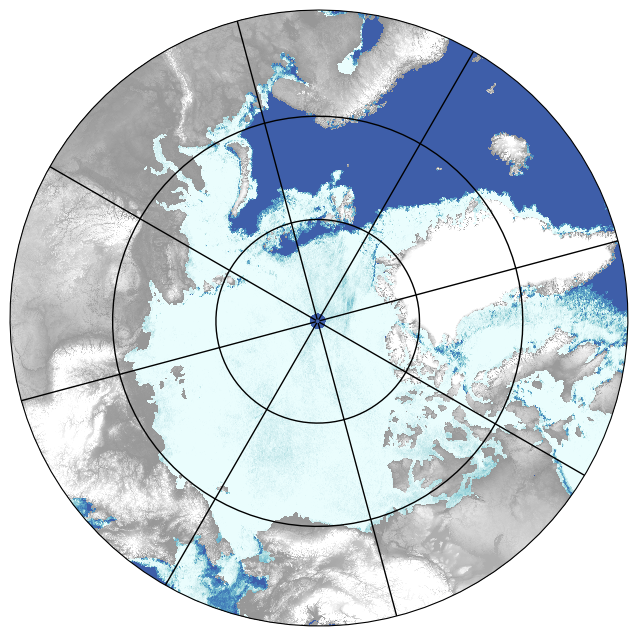

In [8]:



map_projection = ccrs.NorthPolarStereo(central_longitude=210)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=map_projection))



# set extent
ax.set_extent([0, 359, 60, 90], ccrs.PlateCarree())
# Compute a circle in axes coordinates, use as a boundary for the map. 
# Pan/zoom - the boundary will be permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)



newcmap = cmocean.tools.crop_by_percent(cmocean.cm.ice, 25, which='min', N=None)


# format map appearance
ax.patch.set_facecolor(cmocean.cm.ice(0.4))
# add_land(ax, color='lightgray', alpha=1, zorder=2)

ax.pcolormesh(lon_elev, lat_elev, 
#               elev,
              ma.masked_where(elev<0,elev),
              cmap='Greys_r', vmin=-1000, vmax=1000, transform=ccrs.PlateCarree(), zorder=1)

# ax.add_feature(cartopy.feature.OCEAN)
# ax.add_feature(cartopy.feature.LAND)
# add_coast(ax, scale='50m', color='k', linewidth=1, alpha=1, zorder=2)

add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,45), 
         linewidth=1, color='k', alpha=1, zorder=4)


# plot ice
sp = 1
icemesh = ax.pcolormesh(xx[::sp,::sp],yy[::sp,::sp],
                        ma.masked_where(sic[::sp,::sp]>100, ma.masked_where(sic[::sp,::sp]<30, sic[::sp,::sp])),
                        cmap=newcmap, vmin=0, vmax=100, transform=proj)

# plt.colorbar(icemesh)
plt.show()


# save image
#-----------
# saveimage = '/Users/mackenziejewell/Desktop/map.png'
# if saveimage != False:
#     print(f'Saving image as >>> {saveimage}')
#     fig.savefig(saveimage, transparent=False, bbox_inches="tight", pad_inches = 0.05, dpi=300)



In [78]:
# specify date
#=============================================
date_i = datetime.datetime(1985, 8, 17, 0, 0)
#=============================================
num = 1#464+56+3

dates = [date_i+datetime.timedelta(days=30*ii) for ii in range(num)]

# dates = [date_i]

dates

[datetime.datetime(1985, 8, 17, 0, 0)]

In [80]:

for date in dates:
    
#     out = grab_ASI_SIC(date=date, return_vars=['xx', 'yy', 'sic', 'proj'], 
#                         include_units=False, quiet=True)
#     (xx,yy,sic,proj) = out


    
    map_projection = ccrs.NearsidePerspective(central_longitude=210.0, central_latitude=90.0, 
                                              satellite_height=2000000)
    fig, ax = plt.subplots(figsize=(2.75,2.75), subplot_kw=dict(projection=map_projection))

    # format map appearance
#     ax.add_feature(cartopy.feature.OCEAN, color = [0.95,0.95,0.95])
    ax.add_feature(cartopy.feature.OCEAN, color = cmocean.cm.ice(0.25))
    add_land(ax, color=[0.7,0.7,0.7], alpha=1, zorder=2)
    add_grid(ax, lats=np.arange(40,90,10), lons=np.arange(0,360,45), 
             linewidth=0.5, color='k', alpha=1, zorder=4)
    ax.set_global()
    
    
    # plot age
    out = grab_iceage(date=date, select_date='nearest', 
                  return_vars=['lon', 'lat', 'age', 'selected_date'], 
                  mask_flags=True, quiet=True)
    (age_lon, age_lat, age, actualdate) = out
    plot_MYI(ax, age_lon, age_lat, ma.masked_where(age<1, age))
    

    # plot ice
#     sp = 1
#     newcmap = cmocean.tools.crop_by_percent(cmocean.cm.ice, 25, which='min', N=None)
#     icemesh = ax.pcolormesh(xx[::sp,::sp],yy[::sp,::sp],
#                             ma.masked_where(sic[::sp,::sp]>100, ma.masked_where(sic[::sp,::sp]<15, sic[::sp,::sp])),
#                             cmap=newcmap, vmin=0, vmax=100, zorder=1, transform=proj)
    # plot age
#     colors = [cmocean.cm.ice(0.55),cmocean.cm.ice(0.8),'white']
# #     colors = ["darkorange", "gold", 'white']
#     cmap = ListedColormap(colors)
#     norm = matplotlib.colors.BoundaryNorm([0.5,1.5,2.5,10.5], ncolors=len(colors))
#     iceage = ax.pcolormesh(age_lon, age_lat, ma.masked_where(age<1, ma.masked_where(age>15, age)),
#                   cmap=cmap, norm=norm, zorder=2, 
#                   transform=ccrs.PlateCarree())

    add_date(fig, ax, date, date_format='%b %Y', method='manual', 
         boxstyle='round,pad=0.,rounding_size=0.2', facecolor='None', edgecolor='None', 
         zorder=10, x=-0.01, y=1.05, textcolor='k', fontsize=10)
    
    # plt.colorbar(iceage)

#     plt.show()


    # save image
    #-----------
    saveimage = f"/Users/mackenziejewell/Desktop/maps/n4/map_{date.strftime('%Y%m%d')}.png"
    if saveimage != False:
#         print(f'Saving image as >>> {saveimage}')
        fig.savefig(saveimage, transparent=False, bbox_inches="tight", pad_inches = 0.05, dpi=300)
        
    plt.clf()


/Users/mackenziejewell/Documents/GitHub/PrettyPolarPlots/../Libraries_functions/LIB_iceage_NSIDC0611.py:73: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds.indexes['time'].to_datetimeindex()
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


<Figure size 275x275 with 0 Axes>

In [89]:
# specify date
#=============================================
date_i = datetime.datetime(2021, 1, 30, 0, 0)
#=============================================
num = 52

dates = [date_i+datetime.timedelta(days=4*ii) for ii in range(num)]


/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically i

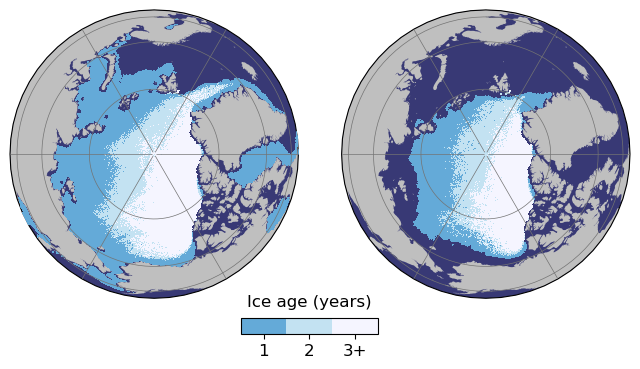

In [11]:

map_projection = ccrs.NearsidePerspective(central_longitude=210.0, central_latitude=90.0, 
                                              satellite_height=2000000)

fig = plt.figure(figsize=[8,4])
ax1 = plt.subplot(1, 2, 1, projection=map_projection)
ax2 = plt.subplot(1, 2, 2, projection=map_projection,
                  sharex=ax1, sharey=ax1)
# fig.subplots_adjust(bottom=0.05, top=0.95,
#                     left=0.04, right=0.95, wspace=0.02)
fig.subplots_adjust(wspace=0.15)

for ax in [ax1, ax2]:
    
    # Limit the map to -60 degrees latitude and below.
#     ax.set_extent([0, 359, 60, 90], ccrs.PlateCarree())
#     ax.patch.set_facecolor([0.95,0.95,0.95])
    ax.patch.set_facecolor(cmocean.cm.ice(0.25))
    add_land(ax, color=[0.75,0.75,0.75], alpha=1, zorder=2)
    add_grid(ax, lats=np.arange(40,90,10), lons=np.arange(0,360,60), 
             linewidth=0.5, color=[0.45,0.45,0.45], alpha=1, zorder=4)

    
# out = grab_iceage(date=datetime.datetime(2021, 3, 1, 0, 0), select_date='nearest', 
#                   return_vars=['lon', 'lat', 'age', 'selected_date'], 
#                   mask_flags=True, quiet=True)
# (age_lon, age_lat, age, actualdate) = out
# plot_MYI(ax2, age_lon, age_lat, ma.masked_where(age<1, age))


median_age = find_median_age_bydate(month = '3', day = '1', years = np.arange(1984,2023))
plot_MYI(ax1, age_lon, age_lat, ma.masked_where(median_age<1, median_age))



# out = grab_iceage(date=datetime.datetime(2021, 9, 1, 0, 0), select_date='nearest', 
#                   return_vars=['lon', 'lat', 'age', 'selected_date'], 
#                   mask_flags=True, quiet=True)
# (age_lon, age_lat, age, actualdate) = out
# plot_MYI(ax2, age_lon, age_lat, ma.masked_where(age<1, age))


median_age = find_median_age_bydate(month = '9', day = '1', years = np.arange(1984,2023))
ice_age = plot_MYI(ax2, age_lon, age_lat, ma.masked_where(median_age<1, median_age))



add_colorbar(fig, ax2, [ice_age], cb_placement='bottom', cb_orientation='auto', cb_width=0.04, 
             cb_length_fraction=[-0.35, 0.125], cb_pad=0.05, cb_ticks=[1,2,3], cb_ticklabels=[1,2,'3+'],
#              cb_length_fraction=[0.5, 0.9], cb_pad=0.025, cb_ticks=[1,2,3], cb_ticklabels=[1,2,'3+'],
             cb_extend='neither', cb_label='Ice age (years)', labelpad=8, cb_label_placement='top', 
             cb_tick_placement='auto', cb_labelsize=12, draw_edges=False, edge_params=['k', 2])


# # open NSIDC-derived drift data
# #------------------------------
# PPD = '/Volumes/Jewell_EasyStore/SIDEx2021/OverviewData/mean_PPdrift_Mar_1990-2000.nc'
# ds_PPD = xr.open_dataset(PPD)
# ds_PPD.close()
# longrid_ice = ds_PPD.longitude.values
# latgrid_ice = ds_PPD.latitude.values
# u_ice = ds_PPD.u.values
# v_ice = ds_PPD.v.values

# sp = 10
# ax1.quiver(longrid_ice[::sp,::sp],latgrid_ice[::sp,::sp], 
#           *fix_cartopy_vectors(u_ice[::sp,::sp],v_ice[::sp,::sp],latgrid_ice[::sp,::sp]), 
#            scale = 80,headwidth=5,width=0.0025,
# #           scale=300, headwidth=5, headlength=4, headaxislength=4,
# #            width=0.05, color='gray', alpha=0.5, 
#            transform=ccrs.PlateCarree(), zorder=15)

# # open NSIDC-derived drift data
# #------------------------------
# PPD = '/Volumes/Jewell_EasyStore/SIDEx2021/OverviewData/mean_PPdrift_Mar_2010-2020.nc'
# ds_PPD = xr.open_dataset(PPD)
# ds_PPD.close()
# longrid_ice = ds_PPD.longitude.values
# latgrid_ice = ds_PPD.latitude.values
# u_ice = ds_PPD.u.values
# v_ice = ds_PPD.v.values

# sp = 10
# ax2.quiver(longrid_ice[::sp,::sp],latgrid_ice[::sp,::sp], 
#           *fix_cartopy_vectors(u_ice[::sp,::sp],v_ice[::sp,::sp],latgrid_ice[::sp,::sp]), 
#            scale = 80,headwidth=5,width=0.0025,
# #           scale=300, headwidth=5, headlength=4, headaxislength=4,
# #            width=0.05, color='gray', alpha=0.5, 
#            transform=ccrs.PlateCarree(), zorder=15)

# save image
#-----------
saveimage = f"/Users/mackenziejewell/Desktop/map_Dec.png"
if saveimage != False:
#         print(f'Saving image as >>> {saveimage}')
    fig.savefig(saveimage, transparent=False, bbox_inches="tight", pad_inches = 0.05, dpi=300)

plt.show()

In [26]:
from shapely import wkt

ds_mask = xr.open_dataset('/Users/mackenziejewell/Documents/GitHub/SIDEx/data/coast_mask_regions_v7.nc')
ds_mask.close()
polyR1 = wkt.loads(str(ds_mask.R1_poly_str.values))
polyR2 = wkt.loads(str(ds_mask.R2_poly_str.values))
coast_poly = wkt.loads(str(ds_mask.coast_poly_masked_str.values))


/Users/mackenziejewell/Documents/GitHub/PrettyPolarPlots/../Libraries_functions/LIB_iceage_NSIDC0611.py:73: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds.indexes['time'].to_datetimeindex()
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


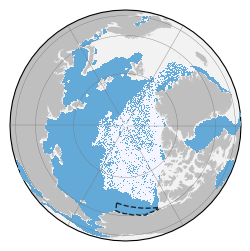

In [27]:

map_projection = ccrs.NearsidePerspective(central_longitude=210.0, central_latitude=90.0, 
                                              satellite_height=2000000)
# map_projection = ccrs.NearsidePerspective(central_longitude=210.0, central_latitude=80.0, 
#                                               satellite_height=5000000)

fig = plt.figure(figsize=[3,3])
ax = plt.subplot(projection=map_projection)

ax.set_global()
# ax.add_feature(cartopy.feature.OCEAN, color = cmocean.cm.ice(0.25))
ax.add_feature(cartopy.feature.OCEAN, color = [0.95,0.95,0.95])
add_land(ax, color=[0.75,0.75,0.75], alpha=1, zorder=2)
add_grid(ax, lats=np.arange(40,90,10), lons=np.arange(0,360,60), 
         linewidth=0.25, color=[0.45,0.45,0.45], alpha=1, zorder=4)

# age
#-------------------------------------------------------------------
# across years
# median_age = find_median_age_bydate(month = '3', day = '1', years = np.arange(2010,2021))
# plot_MYI(ax, age_lon, age_lat, ma.masked_where(median_age<1, median_age))

# single year
age = grab_iceage(date=datetime.datetime(year = 2013, month=3, day=1), select_date='nearest', 
                  return_vars=['age'],  mask_flags=True, quiet=True)
ice_age = plot_MYI(ax, age_lon, age_lat, ma.masked_where(age<1, age))
#-------------------------------------------------------------------


# sic
#-------------------------------------------------------------------
# date = datetime.datetime(year = 2021, month=3, day=15)
# out = grab_ASI_SIC(date=date, return_vars=['xx', 'yy', 'sic', 'proj'], 
#                     include_units=False, quiet=True)
# (xx,yy,sic,proj) = out
# sp = 1
# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.ice, 25, which='min', N=None)
# icemesh = ax.pcolormesh(xx[::sp,::sp],yy[::sp,::sp],
#                         ma.masked_where(sic[::sp,::sp]>100, ma.masked_where(sic[::sp,::sp]<30, sic[::sp,::sp])),
#                         cmap=newcmap, vmin=0, vmax=100, transform=proj)
#-------------------------------------------------------------------

# open NSIDC-derived drift data
#------------------------------
# PPD = '/Volumes/Jewell_EasyStore/SIDEx2021/OverviewData/mean_PPdrift_Mar_2010-2020.nc'
# ds_PPD = xr.open_dataset(PPD)
# ds_PPD.close()
# longrid_ice = ds_PPD.longitude.values
# latgrid_ice = ds_PPD.latitude.values
# u_ice = ds_PPD.u.values
# v_ice = ds_PPD.v.values

# sp = 7
# ax.quiver(longrid_ice[::sp,::sp],latgrid_ice[::sp,::sp], 
#           *fix_cartopy_vectors(u_ice[::sp,::sp],v_ice[::sp,::sp],latgrid_ice[::sp,::sp]), 
#            scale = 70,headwidth=5,width=0.005,color=[0.5,0.5,0.5],
# #           scale=300, headwidth=5, headlength=4, headaxislength=4,
# #            width=0.05, color='gray', alpha=0.5, 
#            transform=ccrs.PlateCarree(), zorder=15)

# add_colorbar(fig, ax, [ice_age], cb_placement='top', cb_orientation='auto', cb_width=0.04, 
#              cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[1,2], cb_ticklabels=[1,'2+'],
# #              cb_length_fraction=[0.5, 0.9], cb_pad=0.025, cb_ticks=[1,2,3], cb_ticklabels=[1,2,'3+'],
#              cb_extend='neither', cb_label='Ice age (years)', labelpad=8, cb_label_placement='auto', 
#              cb_tick_placement='auto', cb_labelsize=12, draw_edges=False, edge_params=['k', 2])

# plt.show()

ax.add_geometries([coast_poly], edgecolor='k', linestyle='dashed', facecolor='None',alpha=0.75, crs= ccrs.PlateCarree(), zorder=10)

# save image
#-----------
saveimage = f"/Users/mackenziejewell/Desktop/map_Dec.png"
if saveimage != False:
#         print(f'Saving image as >>> {saveimage}')
    fig.savefig(saveimage, transparent=True, bbox_inches="tight", pad_inches = 0.05, dpi=300)


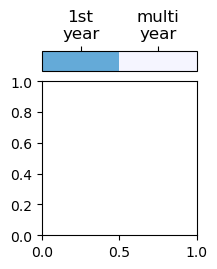

In [29]:
fig, ax = plt.subplots(figsize=[2,2])
add_colorbar(fig, ax, [ice_age], cb_placement='top', cb_orientation='auto', cb_width=0.1, 
             cb_length_fraction=[0,1], cb_pad=0.05, cb_ticks=[1,2], cb_ticklabels=['1st\nyear','multi\nyear'],
#              cb_length_fraction=[0.5, 0.9], cb_pad=0.025, cb_ticks=[1,2,3], cb_ticklabels=[1,2,'3+'],
             cb_extend='neither', cb_label='', labelpad=8, cb_label_placement='auto', 
             cb_tick_placement='auto', cb_labelsize=12, draw_edges=False, edge_params=['k', 2])

# save image
#-----------
saveimage = f"/Users/mackenziejewell/Desktop/map_Dec.png"
if saveimage != False:
#         print(f'Saving image as >>> {saveimage}')
    fig.savefig(saveimage, transparent=True, bbox_inches="tight", pad_inches = 0.05, dpi=300)


In [83]:
saveimage

'/Users/mackenziejewell/Desktop/map_Dec.png'

/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


NameError: name 'age_lon' is not defined

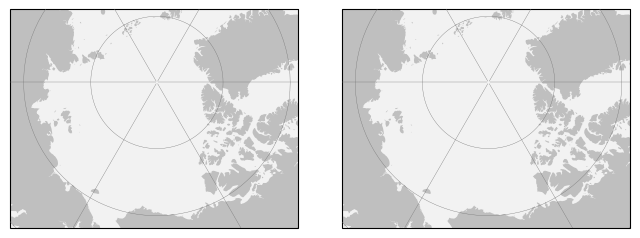

In [9]:

map_projection = ccrs.NorthPolarStereo(central_longitude=210)

fig = plt.figure(figsize=[8,4])
ax1 = plt.subplot(1, 2, 1, projection=map_projection)
ax2 = plt.subplot(1, 2, 2, projection=map_projection,
                  sharex=ax1, sharey=ax1)
# fig.subplots_adjust(bottom=0.05, top=0.95,
#                     left=0.04, right=0.95, wspace=0.02)
fig.subplots_adjust(wspace=0.15)

for ax in [ax1, ax2]:
    ax.set_extent([120, 330, 68, 90], ccrs.PlateCarree())
    
    # Limit the map to -60 degrees latitude and below.
#     ax.set_extent([0, 359, 60, 90], ccrs.PlateCarree())
    ax.patch.set_facecolor([0.95,0.95,0.95])
#     ax.patch.set_facecolor(cmocean.cm.ice(0.25))
    add_land(ax, color=[0.75,0.75,0.75], alpha=1, zorder=2)
    add_grid(ax, lats=np.arange(40,90,10), lons=np.arange(0,360,60), 
             linewidth=0.5, color=[0.45,0.45,0.45], alpha=1, zorder=4)

    
# out = grab_iceage(date=datetime.datetime(2021, 3, 1, 0, 0), select_date='nearest', 
#                   return_vars=['lon', 'lat', 'age', 'selected_date'], 
#                   mask_flags=True, quiet=True)
# (age_lon, age_lat, age, actualdate) = out
# plot_MYI(ax2, age_lon, age_lat, ma.masked_where(age<1, age))


median_age = find_median_age_bydate(month = '3', day = '15', years = np.arange(1990,2000))
plot_MYI(ax1, age_lon, age_lat, ma.masked_where(median_age<1, median_age))



# out = grab_iceage(date=datetime.datetime(2021, 9, 1, 0, 0), select_date='nearest', 
#                   return_vars=['lon', 'lat', 'age', 'selected_date'], 
#                   mask_flags=True, quiet=True)
# (age_lon, age_lat, age, actualdate) = out
# plot_MYI(ax2, age_lon, age_lat, ma.masked_where(age<1, age))


median_age = find_median_age_bydate(month = '3', day = '15', years = np.arange(2010,2020))
ice_age = plot_MYI(ax2, age_lon, age_lat, ma.masked_where(median_age<1, median_age))



add_colorbar(fig, ax2, [ice_age], cb_placement='top', cb_orientation='auto', cb_width=0.025, 
             cb_length_fraction=[-0.4, 0.125], cb_pad=0.05, cb_ticks=[1,2,3], cb_ticklabels=[1,2,'3+'],
#              cb_length_fraction=[0.5, 0.9], cb_pad=0.025, cb_ticks=[1,2,3], cb_ticklabels=[1,2,'3+'],
             cb_extend='neither', cb_label='Ice age (years)', labelpad=8, cb_label_placement='auto', 
             cb_tick_placement='auto', cb_labelsize=12, draw_edges=False, edge_params=['k', 2])


# open NSIDC-derived drift data
#------------------------------
PPD = '/Volumes/Jewell_EasyStore/SIDEx2021/OverviewData/mean_PPdrift_Mar_1990-2000.nc'
ds_PPD = xr.open_dataset(PPD)
ds_PPD.close()
longrid_ice = ds_PPD.longitude.values
latgrid_ice = ds_PPD.latitude.values
u_ice = ds_PPD.u.values
v_ice = ds_PPD.v.values

sp = 10
ax1.quiver(longrid_ice[::sp,::sp],latgrid_ice[::sp,::sp], 
          *fix_cartopy_vectors(u_ice[::sp,::sp],v_ice[::sp,::sp],latgrid_ice[::sp,::sp]), 
           scale = 0,headwidth=5,width=0.0025,
#           scale=300, headwidth=5, headlength=4, headaxislength=4,
#            width=0.05, color='gray', alpha=0.5, 
           transform=ccrs.PlateCarree(), zorder=15)

# open NSIDC-derived drift data
#------------------------------
PPD = '/Volumes/Jewell_EasyStore/SIDEx2021/OverviewData/mean_PPdrift_Mar_2010-2020.nc'
ds_PPD = xr.open_dataset(PPD)
ds_PPD.close()
longrid_ice = ds_PPD.longitude.values
latgrid_ice = ds_PPD.latitude.values
u_ice = ds_PPD.u.values
v_ice = ds_PPD.v.values

sp = 10
ax2.quiver(longrid_ice[::sp,::sp],latgrid_ice[::sp,::sp], 
          *fix_cartopy_vectors(u_ice[::sp,::sp],v_ice[::sp,::sp],latgrid_ice[::sp,::sp]), 
           scale = 0,headwidth=5,width=0.0025,
#           scale=300, headwidth=5, headlength=4, headaxislength=4,
#            width=0.05, color='gray', alpha=0.5, 
           transform=ccrs.PlateCarree(), zorder=15)

# save image
#-----------
saveimage = f"/Users/mackenziejewell/Desktop/map_Dec.png"
if saveimage != False:
#         print(f'Saving image as >>> {saveimage}')
    fig.savefig(saveimage, transparent=False, bbox_inches="tight", pad_inches = 0.05, dpi=300)

plt.show()

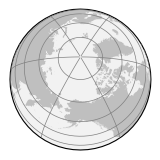

In [124]:

map_projection = ccrs.NearsidePerspective(central_longitude=210.0, central_latitude=80.0, 
                                              satellite_height=5000000)

fig = plt.figure(figsize=[4,4])
ax = plt.subplot(1, 2, 1, projection=map_projection)

ax.add_feature(cartopy.feature.OCEAN, color = [0.95,0.95,0.95])
# ax.patch.set_facecolor([0.95,0.95,0.95])
add_land(ax, color=[0.75,0.75,0.75], alpha=1, zorder=2)
add_grid(ax, lats=np.arange(40,90,10), lons=np.arange(0,360,60), 
         linewidth=0.5, color=[0.5,0.5,0.5], alpha=1, zorder=4)

# save image
#-----------
saveimage = f"/Users/mackenziejewell/Desktop/general.png"
if saveimage != False:
#         print(f'Saving image as >>> {saveimage}')
    fig.savefig(saveimage, transparent=True, bbox_inches="tight", pad_inches = 0.05, dpi=300)

plt.show()

/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


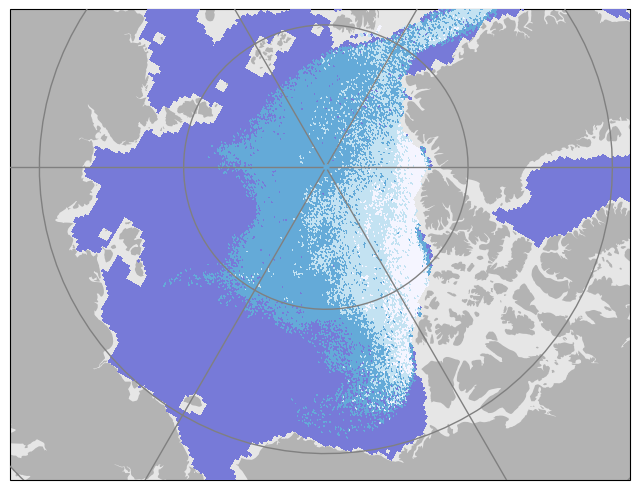

(-2486689.930828881,
 2394537.0171020906,
 -2463543.782465608,
 1243344.9654144407)

In [109]:


map_projection = ccrs.NorthPolarStereo(central_longitude=210)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=map_projection))



# set extent
ax.set_extent([120, 330, 68, 90], ccrs.PlateCarree())
# Compute a circle in axes coordinates, use as a boundary for the map. 
# Pan/zoom - the boundary will be permanently circular.
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)
# ax.set_boundary(circle, transform=ax.transAxes)



newcmap = cmocean.tools.crop_by_percent(cmocean.cm.ice, 25, which='min', N=None)


# format map appearance
ax.patch.set_facecolor([0.9,0.9,0.9])
add_land(ax, color=[0.7,0.7,0.7], alpha=1, zorder=2)


# ax.add_feature(cartopy.feature.OCEAN)
# ax.add_feature(cartopy.feature.LAND)
# add_coast(ax, scale='50m', color='k', linewidth=1, alpha=1, zorder=2)

add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,60), 
         linewidth=1, color='gray', alpha=1, zorder=4)


median_age = find_median_age_bydate(month = '12', day = '15', years = np.arange(2010,2020))
ice_age = plot_MYI(ax, age_lon, age_lat, ma.masked_where(median_age<1, median_age))

# plt.colorbar(icemesh)
plt.show()


# save image
#-----------
# saveimage = '/Users/mackenziejewell/Desktop/map.png'
# if saveimage != False:
#     print(f'Saving image as >>> {saveimage}')
#     fig.savefig(saveimage, transparent=False, bbox_inches="tight", pad_inches = 0.05, dpi=300)

ax.get_extent()


In [ ]:
map_projection = ccrs.NearsidePerspective(central_longitude=210.0, central_latitude=80.0, 
                                              satellite_height=5000000)

fig = plt.figure(figsize=[6,4])
ax1 = plt.subplot(1, 2, 1, projection=map_projection)

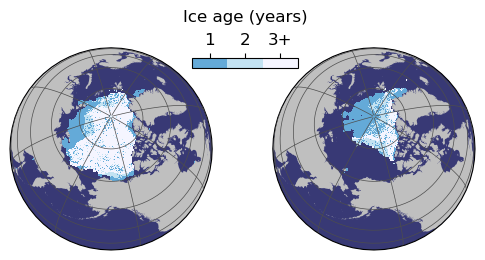

In [191]:
map_projection = ccrs.NearsidePerspective(central_longitude=210.0, central_latitude=80.0, 
                                              satellite_height=5000000)

fig = plt.figure(figsize=[6,4])
ax1 = plt.subplot(1, 2, 1, projection=map_projection)
ax2 = plt.subplot(1, 2, 2, projection=map_projection,
                  sharex=ax1, sharey=ax1)
# fig.subplots_adjust(bottom=0.05, top=0.95,
#                     left=0.04, right=0.95, wspace=0.02)
fig.subplots_adjust(wspace=0.3)

for ax in [ax1, ax2]:
    
    # Limit the map to -60 degrees latitude and below.
#     ax.set_extent([0, 359, 60, 90], ccrs.PlateCarree())
#     ax.patch.set_facecolor([0.95,0.95,0.95])
    ax.patch.set_facecolor(cmocean.cm.ice(0.25))
    add_land(ax, color=[0.75,0.75,0.75], alpha=1, zorder=2)
    add_grid(ax, lats=np.arange(40,90,10), lons=np.arange(0,360,45), 
             linewidth=0.5, color=[0.3,0.3,0.3], alpha=1, zorder=4)

    
out = grab_iceage(date=datetime.datetime(1984, 9, 1, 0, 0), select_date='nearest', 
                  return_vars=['lon', 'lat', 'age', 'selected_date'], 
                  mask_flags=True, quiet=True)
(age_lon, age_lat, age, actualdate) = out
plot_MYI(ax1, age_lon, age_lat, ma.masked_where(age<1, age))


out = grab_iceage(date=datetime.datetime(2012, 9, 1, 0, 0), select_date='nearest', 
                  return_vars=['lon', 'lat', 'age', 'selected_date'], 
                  mask_flags=True, quiet=True)
(age_lon, age_lat, age, actualdate) = out
plot_MYI(ax2, age_lon, age_lat, ma.masked_where(age<1, age))


add_colorbar(fig, ax2, [ice_age], cb_placement='top', cb_orientation='auto', cb_width=0.025, 
             cb_length_fraction=[-0.4, 0.125], cb_pad=-0.05, cb_ticks=[1,2,3], cb_ticklabels=[1,2,'3+'],
#              cb_length_fraction=[0.5, 0.9], cb_pad=0.025, cb_ticks=[1,2,3], cb_ticklabels=[1,2,'3+'],
             cb_extend='neither', cb_label='Ice age (years)', labelpad=8, cb_label_placement='auto', 
             cb_tick_placement='auto', cb_labelsize=12, draw_edges=False, edge_params=['k', 2])
plt.show()

# save image
#-----------
saveimage = f"/Users/mackenziejewell/Desktop/map_Sept_1984_2012.png"
if saveimage != False:
#         print(f'Saving image as >>> {saveimage}')
    fig.savefig(saveimage, transparent=False, bbox_inches="tight", pad_inches = 0.05, dpi=300)


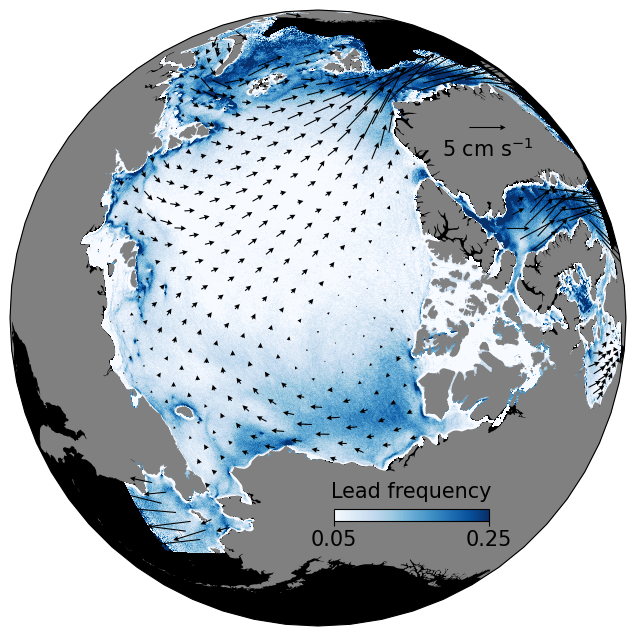

In [93]:

map_projection = ccrs.NearsidePerspective(central_longitude=210.0, central_latitude=80.0, 
                                              satellite_height=1700000)
# map_projection = ccrs.NorthPolarStereo(central_longitude=220.0)

fig, ax = plt.subplots(figsize=[8,8], subplot_kw = {'projection':map_projection})

    
# Limit the map to -60 degrees latitude and below.
# ax.set_extent([0, 359, 68, 90], ccrs.PlateCarree())
ax.patch.set_facecolor('k')#[0.25,0.25,0.25])
# ax.patch.set_facecolor(cmocean.cm.ice(0.25))
add_land(ax, color='gray', alpha=1, zorder=2)
# add_grid(ax, lats=np.arange(40,90,10), lons=np.arange(0,360,60), 
#          linewidth=0.5, color=[0.45,0.45,0.45], alpha=1, zorder=4)


# cmap = cmocean.tools.crop_by_percent(cmocean.cm.ice_r, 1, which='max', N=None)
cmap = cm.Blues
mesh = ax.pcolormesh(lon, lat, freq, vmin=0.05, vmax = 0.25, cmap=cmap, transform=ccrs.PlateCarree())



add_colorbar(fig, ax, [mesh],
             cb_placement='bottom', cb_orientation='auto', cb_width=0.015, 
             cb_length_fraction=[0.525,0.775], cb_pad=-0.135, cb_ticks=[0.05, 0.25], #cb_ticklabels=['5%''25%'],
#              cb_length_fraction=[0.5, 0.9], cb_pad=0.025, cb_ticks=[1,2,3], cb_ticklabels=[1,2,'3+'],
             cb_extend='neither', cb_label='Lead frequency', labelpad=8, cb_label_placement='top', 
             cb_tick_placement='auto', cb_labelsize=15, draw_edges=False, edge_params=['k', 2])


# open NSIDC-derived drift data
#------------------------------
PPD = '/Volumes/Jewell_EasyStore/SIDEx2021/OverviewData/mean_PPdrift_Mar_1990-2000.nc'
ds_PPD = xr.open_dataset(PPD)
ds_PPD.close()
longrid_ice = ds_PPD.longitude.values
latgrid_ice = ds_PPD.latitude.values
u_ice = ds_PPD.u.values
v_ice = ds_PPD.v.values

sp = 6
q = ax.quiver(longrid_ice[::sp,::sp],latgrid_ice[::sp,::sp], 
          *fix_cartopy_vectors(u_ice[::sp,::sp],v_ice[::sp,::sp],latgrid_ice[::sp,::sp]), 
          color='k',#[0.3,0.3,0.3],
           scale = 85,headwidth=5,width=0.00175,
#           scale=300, headwidth=5, headlength=4, headaxislength=4,
#            width=0.05, color='gray', alpha=0.5, 
           transform=ccrs.PlateCarree(), zorder=15)

qk = plt.quiverkey(q, 0.775, 0.81, 5,
                   '5 cm s$^{-1}$',
                   labelpos='S',
                   transform=ax.transAxes,
                   color='k', fontproperties={'size':15})

# save image
#-----------
saveimage = f"/Users/mackenziejewell/Desktop/lead_frequency.png"
if saveimage != False:
#         print(f'Saving image as >>> {saveimage}')
    fig.savefig(saveimage, transparent=True, bbox_inches="tight", pad_inches = 0.0, dpi=300)

plt.show()




In [44]:
ds2 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/Reiser_LeadFrequency_20022019/Arctic_Relleads_2002_2019.nc')
ds2.close()

sp = 3
freq = ma.masked_where(ds2.LeadFrequency[::sp,::sp] == 0, 
                       ma.masked_where(ds2.LeadFrequency[::sp,::sp] == 255, ds2.LeadFrequency[::sp,::sp]/255))
lat = ds2.Latitude[::sp,::sp]
lon = ds2.Longitude[::sp,::sp]


In [100]:
data = {}
data['sic'] = grab_ASI_SIC(date=datetime.datetime(2018,1,1),
             main_path='/Volumes/Jewell_EasyStore/UniB-ASI-SIC-n6250/', 
             coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
             hemisphere='n', resolution='6250', version='v5.4', 
             return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
             include_units=False, annual_folders=True, return_dict=True, quiet=True)


(720.0, 1180.0)

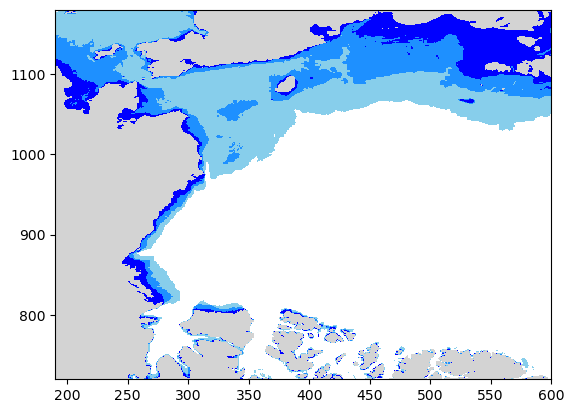

In [186]:

ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO_2023_Beaufort/re-gridded/GEBCO_625kmASIgrid_TEST.nc')
ds.close()

LAND2 = np.full(data['sic']['xx'].shape, False)
LAND2[720:1180, 190:600] = ds.mean_z.values >= -20

LAND = np.full(data['sic']['xx'].shape, False)
LAND[720:1180, 190:600] = ds.mean_z.values >= 0

INNER = np.full(data['sic']['xx'].shape, False)
INNER[720:1180, 190:600] = (ds.mean_z.values >= -20) & (ds.mean_z.values < 0)

MID = np.full(data['sic']['xx'].shape, False)
MID[720:1180, 190:600] = (ds.mean_z.values >= -40) & (ds.mean_z.values < -20)

OUTER = np.full(data['sic']['xx'].shape, False)
OUTER[720:1180, 190:600] = (ds.mean_z.values >= -100) & (ds.mean_z.values < -40)


%matplotlib inline
fig, ax = plt.subplots()
ax.pcolormesh(LAND, cmap=matplotlib.colors.ListedColormap(['None', 'lightgray']))
ax.pcolormesh(INNER, cmap=matplotlib.colors.ListedColormap(['None', 'blue']))
ax.pcolormesh(MID, cmap=matplotlib.colors.ListedColormap(['None', 'dodgerblue']))
ax.pcolormesh(OUTER, cmap=matplotlib.colors.ListedColormap(['None', 'skyblue']))
ax.set_xlim(190, 600)
ax.set_ylim(720, 1180)

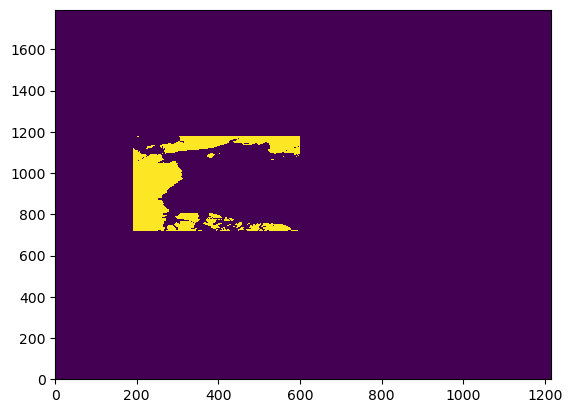

In [187]:
plt.pcolormesh(LAND2)


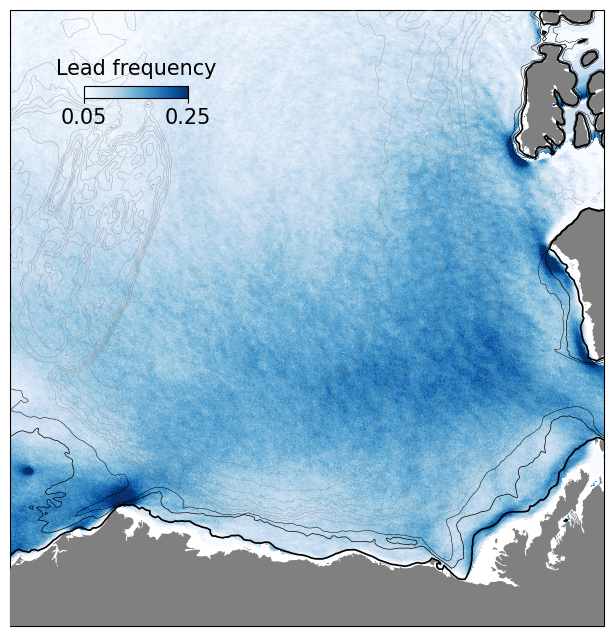

In [211]:

# map_projection = ccrs.NearsidePerspective(central_longitude=210.0, central_latitude=80.0, 
#                                               satellite_height=1700000)
map_projection = ccrs.NorthPolarStereo(central_longitude=205.0)

fig, ax = plt.subplots(figsize=[8,8], subplot_kw = {'projection':map_projection})

    
# Limit the map to -60 degrees latitude and below.
ax.set_extent([198, 230, 69, 80], ccrs.PlateCarree())
# ax.patch.set_facecolor('k')#[0.25,0.25,0.25])
# ax.patch.set_facecolor(cmocean.cm.ice(0.25))
add_land(ax, scale='10m',color='gray', alpha=1, zorder=3)



# cmap = cmocean.tools.crop_by_percent(cmocean.cm.deep_r, 50, which='max', N=None)
# ax.pcolormesh(ds.xx, ds.yy, ds.mean_z, vmin=-3500, vmax=-100, cmap=cmap,
#               transform=data['sic']['proj'], zorder=1)

# cmap2 = cmocean.tools.crop_by_percent(cmocean.cm.deep_r, 50, which='min', N=None)
# ax.pcolormesh(ds.xx, ds.yy, ma.masked_where(ds.mean_z<-100, ds.mean_z), vmin=-100, vmax=-20, cmap=cmap2,
#               transform=data['sic']['proj'], zorder=1)


# cmap = cmocean.tools.crop_by_percent(cmocean.cm.ice_r, 1, which='max', N=None)
cmap = cm.Blues
mesh = ax.pcolormesh(lon, lat, freq, vmin=0.05, vmax = 0.25, cmap=cmap, transform=ccrs.PlateCarree(), zorder=1)


ax.contour(ds.xx, ds.yy, ds.mean_z, levels=np.arange(-3500,0,500), 
           colors='gray', linewidths=[0.2], linestyles='solid', transform=data['sic']['proj'], zorder=100)
ax.contour(ds.xx, ds.yy, ds.mean_z, levels=[-100,-50,-20], 
           colors='k', linewidths=[0.35,0.5,1.25], linestyles='solid', transform=data['sic']['proj'], zorder=100)
# ax.text(0.865,0.325,'20 m',rotation=50, c='k',size=12, transform=ax.transAxes)
# ax.text(0.8,0.35,'50 m',rotation=50, c='k',size=12, transform=ax.transAxes)
# ax.text(0.725,0.32,'100 m',rotation=50, c='k',size=12, transform=ax.transAxes)


ax.pcolormesh(ds.xx, ds.yy, ds.mean_z.values >= -8, 
              cmap=matplotlib.colors.ListedColormap(['None', 'white']),
              transform=data['sic']['proj'], zorder=2)


# ax.pcolormesh(INNER, cmap=matplotlib.colors.ListedColormap(['None', 'blue']))
# ax.pcolormesh(MID, cmap=matplotlib.colors.ListedColormap(['None', 'dodgerblue']))
# ax.pcolormesh(OUTER, cmap=matplotlib.colors.ListedColormap(['None', 'skyblue']))


add_colorbar(fig, ax, [mesh],
             cb_placement='bottom', cb_orientation='auto', cb_width=0.015, 
             cb_length_fraction=[0.125,0.3], cb_pad=-0.675, cb_ticks=[0.05, 0.25], #cb_ticklabels=['5%''25%'],
#              cb_length_fraction=[0.5, 0.9], cb_pad=0.025, cb_ticks=[1,2,3], cb_ticklabels=[1,2,'3+'],
             cb_extend='neither', cb_label='Lead frequency', labelpad=8, cb_label_placement='top', 
             cb_tick_placement='auto', cb_labelsize=15, draw_edges=False, edge_params=['k', 2])



# save image
#-----------
saveimage = f"/Users/mackenziejewell/Desktop/lead_freq_2_large.png"
if saveimage != False:
#         print(f'Saving image as >>> {saveimage}')
    fig.savefig(saveimage, transparent=True, bbox_inches="tight", pad_inches = 0.0, dpi=300)

plt.show()

